In [2]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile

/var/folders/ww/ltx99cqx36v87nl20lt5x_zc0000gn/T/ipykernel_79978/4097809170.py:9: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr, data = wavfile.read(file_path)   # data is typically int16 or int32


Sample rate is:  44100
data [    0  1421  2835 ... -4238 -2836 -1420]
Z-vectors [array([   0, 1421, 2835, 4238, 5625, 6989, 8327, 9632], dtype=int16), array([10899, 12122, 13299, 14423, 15490, 16496, 17438, 18312],
      dtype=int16), array([19113, 19839, 20487, 21055, 21540, 21940, 22254, 22482],
      dtype=int16), array([22620, 22670, 22629, 22500, 22284, 21980, 21590, 21114],
      dtype=int16), array([20555, 19916, 19199, 18406, 17541, 16607, 15608, 14548],
      dtype=int16), array([13429, 12258, 11040,  9778,  8478,  7143,  5781,  4397],
      dtype=int16), array([ 2995,  1581,   161, -1259, -2674, -4080, -5469, -6836],
      dtype=int16), array([ -8177,  -9486, -10756, -11986, -13168, -14297, -15372, -16384],
      dtype=int16), array([-17334, -18216, -19026, -19761, -20417, -20994, -21489, -21899],
      dtype=int16), array([-22222, -22460, -22608, -22668, -22639, -22521, -22313, -22019],
      dtype=int16), array([-21639, -21173, -20624, -19993, -19284, -18500, -17643, -16716

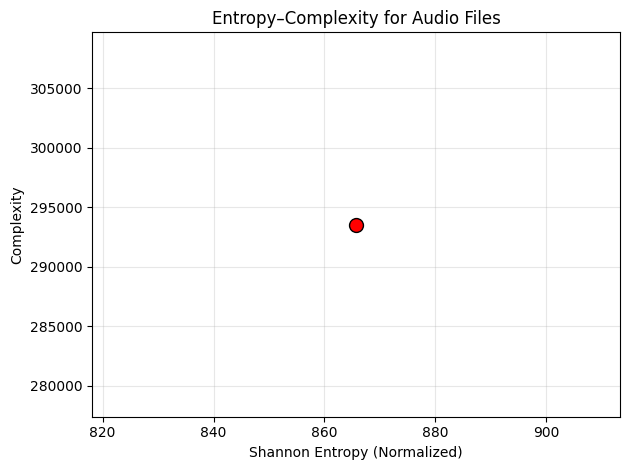

In [ ]:


def create_z_vectors_scipy(file_path, window_size, hop_size):
    """
    Alternative method to create z-vectors from a WAV file using scipy.io.wavfile.
    1. Read a PCM WAV file (16-bit or 32-bit typically).
    2. Convert to float, standardize amplitude.
    3. Create overlapping windows.
    """
    # 1) Read data and sample rate from wav
    sr, data = wavfile.read(file_path)   # data is typically int16 or int32
    print("Sample rate is: ", sr)
    # 2) Convert to mono if multiple channels
    if data.ndim == 2:
        # E.g., shape = (num_samples, num_channels)
        data = data.mean(axis=1)  # simple average to mono

    # 5) Create windows
    num_samples = len(data)
    if hop_size > 0 :
        num_windows = (num_samples - window_size) // hop_size
        print("data",data)
        vectors = []
        for i in range(num_windows):
            start = i * hop_size
            end = start + window_size
            window = data[start:end]
            vectors.append(window)
    else: 
        num_windows = num_samples // window_size
        print("data",data)
        vectors = []
        for i in range(num_windows):
            start = i * window_size
            end = start + window_size
            window = data[start:end]
            vectors.append(window)
    if num_windows < 1:
        raise ValueError("Audio too short for the given window/hop parameters.")

    print('Z-vectors', vectors)
    return np.array(vectors)


def rank_vector(z):
    return np.argsort(z).argsort() + 1


def calculate_shannon_entropy(probabilities):
    """
    Shannon entropy: H = -sum( p[i] * log2( p[i] ) ), ignoring zero-prob terms.
    """
    return -np.sum(probabilities * np.log2(probabilities + 1e-12))


def calculate_jmax(n):
    """
    Maximum possible Jensen–Shannon divergence for distributions of dimension 
        J_max(n) = -2*((n+1)/n*np.log2(n+1)-2*np.log2(n+1)-2*np.log2(2*n)+np.log2(n))
    """
    J_max = -0.5*((n+1)/n*np.log2(n+1)-2*np.log2(n+1)-2*np.log2(2*n)+np.log2(n))
    return J_max


def row_probabilities(ranked_z_vectors):
    # 1) Find unique rows, their counts
    unique_rows, counts = np.unique(ranked_z_vectors, axis=0, return_counts=True)
    
    # 2) Create a dictionary: (row as tuple) -> probability
    freq_map = {}
    for row_u, c in zip(unique_rows, counts):
        freq_map[tuple(row_u)] = c / len(ranked_z_vectors)
    
    # 3) Convert each row in ranked_z_vectors to the probability
    probabilities = np.array([freq_map[tuple(r)] for r in ranked_z_vectors])
    return probabilities


def process_audio(file_path):
    """
    Main function that returns:
      - H:   The *normalized* Shannon entropy of the probability distribution of windows.
      - C(p): Complexity = ( J(p, p_u) / J_max ) * H(p).
      1) Create z-vectors (each is n samples, hopped by m).
      2) Rank each z-vector from 1..n.
      3) Make probabilities
      4) Make uniform probability
      5) Calculate Shannon entropy of p, normalize by log2(#unique_vectors).
      6) Calculate Jensen-Shannon divergence J(p, p_u).
      7) Calculate J_max for #unique_vectors.
      8) Complexity = (J / J_max) * H.
    """
    
    # 1) Create z-vectors
    z_vectors = create_z_vectors_scipy(file_path, 8, 0) # path, window size, hop size
    # print("z-vectors", z_vectors)
    num_windows = len(z_vectors)
    print("num of windows", num_windows)
    print("UNIQUE", len({tuple(row) for row in z_vectors}))
    # print("Num of windows: ", num_windows)
    # print("Num of unique windows:", len(set(z_vectors.flatten())))

    # 2) Rank each window
    ranked_z_vectors = np.array([rank_vector(z) for z in z_vectors])
    print("Ranked z vectors: ", ranked_z_vectors)
    print("UNIQUE", len({tuple(row) for row in ranked_z_vectors}))
    # 3) Make probabilities
    p = row_probabilities(ranked_z_vectors)
    ranked_z_vectors_size = len(ranked_z_vectors)
    print("Probabilities for z vectors: ", p)
    print("Length of z_vector ", ranked_z_vectors_size)
    print("Unique probabilities", set(p.flatten()))

    # 4) Make uniform probability
    p_u = np.ones(ranked_z_vectors_size) / ranked_z_vectors_size
    print("Probabilities for universal distribution: ", p_u)

    # 5) Calculate Shannon entropy of p
    #    H_raw = -sum( p[i] * log2(p[i]) )
    H_raw = calculate_shannon_entropy(p)

    #    Normalize by log2(n_unique) so that H is in [0,1]
    H_max = np.log2(ranked_z_vectors_size)
    H = H_raw / H_max if H_max > 0 else 0.0

    # 6) Jensen-Shannon divergence: J(p, p_u) = S((p+p_u)/2) - 0.5*S(p) - 0.5*S(p_u)
    J = (calculate_shannon_entropy(0.5 * (p + p_u)) - 0.5 * calculate_shannon_entropy(p) - 0.5 * calculate_shannon_entropy(p_u))
    print("Jensen-Shannon divergence: ", J)

    # 7) Calculate J_max
    J_max = calculate_jmax(ranked_z_vectors_size) if ranked_z_vectors_size > 1 else 1e-12  # avoid /0 if n_unique=1
    print("J_max: ", J_max)
    
    # 8) Complexity
    complexity = (J / J_max) * H
    
    return H, complexity


entropy, complexity = process_audio("data/jazz/440wave.wav")
print("Entropy: ", entropy," Complexity: ", complexity)
plt.scatter(entropy, complexity, s=100, c='red', edgecolor='black')
plt.xlabel("Shannon Entropy (Normalized)")
plt.ylabel("Complexity")
plt.title("Entropy–Complexity for Audio Files")

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()